# Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve, roc_curve, auc, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

# Get_Data

In [2]:
# read the data
df = pd.read_csv("./data/titanic_train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# passenger ID is a unique index
# thus can be used as index
df.set_index("PassengerId", inplace=True)

## EDA

In [4]:
# some data: Name, Ticket, Cabin, Embarked
# is assumed to be irrelevant for the further analises
# thus has to be droped otu
df.drop("Name, Ticket, Cabin, Embarked".split(", "), axis=1, inplace=True)

In [5]:
# convert Sex to numeric
df["Sex"] = pd.get_dummies(df["Sex"], drop_first=True)

<AxesSubplot:ylabel='PassengerId'>

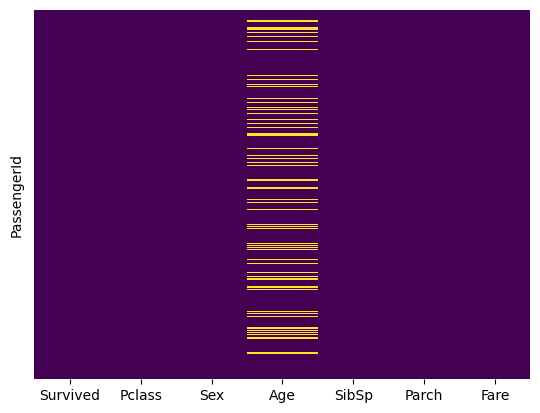

In [6]:
# exploring missing data
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [7]:
# Age shows a missing data that can be inputed
# on option is to fill them with an average age of passangers
df["Age"].fillna(df["Age"].mean(),inplace=True)

# LogisticRegrassion

In [8]:
# split dependent and independent variables
X, y = df.drop("Survived", axis = 1), df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [9]:
logReg = LogisticRegression(max_iter=500).fit(X_train, y_train)

yLogPredictTrain = logReg.predict(X_train)
yLogPredictTest = logReg.predict(X_test)
print(f"Accuracy: {accuracy_score(yLogPredictTrain, y_train)}")

Accuracy: 0.7979041916167665


/Users/dr.rub/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


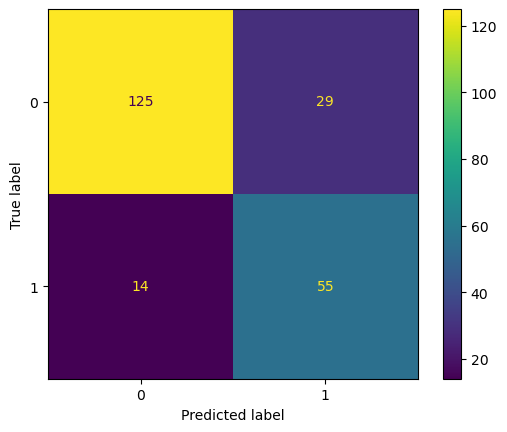

In [10]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(yLogPredictTest, y_test),
                       display_labels=logReg.classes_)

display.plot()

## Potential improvement

### ROC curve

In [11]:
# ROC curve is aimed to get
# trade-off between precision and recall

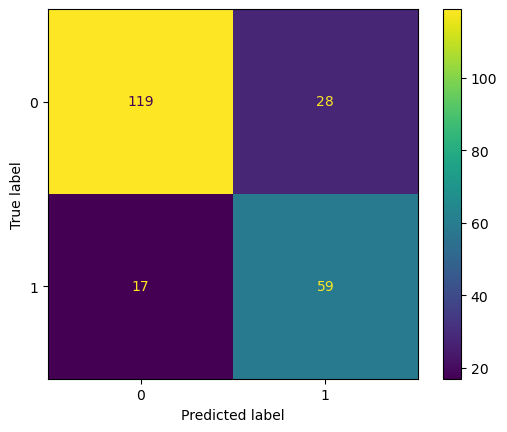

In [12]:
df = pd.read_csv("./data/titanic_train.csv")
df.set_index("PassengerId", inplace=True)
df.drop("Name, Ticket, Cabin, Embarked".split(", "), axis=1, inplace=True)
df["Sex"] = pd.get_dummies(df["Sex"], drop_first=True)
df["Age"].fillna(df["Age"].mean(),inplace=True)

X, y = df.drop("Survived", axis = 1), df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

logReg = LogisticRegression(max_iter=100).fit(X_train, y_train)

yLogPredictTrain = logReg.predict(X_train)
yLogPredictTest = logReg.predict(X_test)

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(yLogPredictTest, y_test),
                       display_labels=logReg.classes_)
display.plot()

Text(0.5, 0, 'FalsePositive')

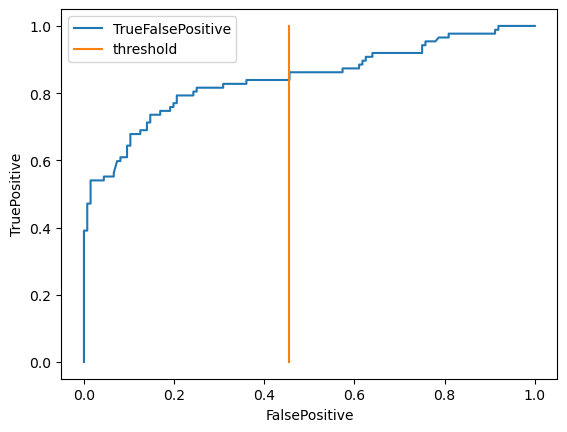

In [13]:
fpr, tpr, threshold = roc_curve(y_test, logReg.predict_proba(X_test)[:,1])
bestThreshould = threshold[(tpr-fpr).argmax()]
plt.plot(fpr, tpr, label = "TrueFalsePositive")
plt.plot([bestThreshould,bestThreshould],[0,1], label = "threshold")
plt.legend()
plt.ylabel("TruePositive")
plt.xlabel("FalsePositive")

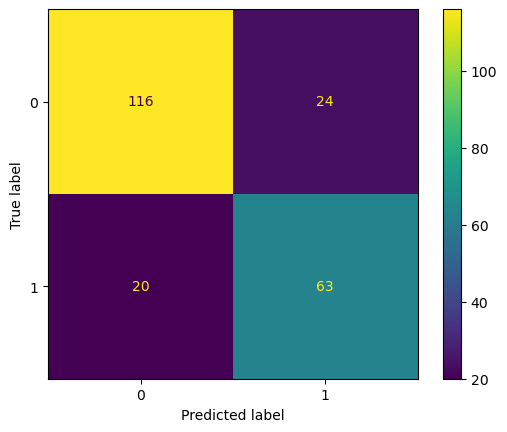

In [14]:
y_test_th = pd.DataFrame(logReg.predict_proba(X_test))
y_test_th = y_test_th[1]>bestThreshould
confMat = confusion_matrix(y_test_th, y_test)
confPlot = ConfusionMatrixDisplay(confMat).plot()

### advanced_Imputing

In [15]:
# Higher score can be reached by better data engeneering

In [16]:
df = pd.read_csv("./data/titanic_train.csv")
df.set_index("PassengerId", inplace=True)
df.drop("Name, Ticket, Cabin, Embarked".split(", "), axis=1, inplace=True)
df["Sex"] = pd.get_dummies(df["Sex"], drop_first=True)

In [17]:
# Since the mean age depends on Sex and Pclass
# it can be taken into account
df_mean_age = df.groupby("Sex, Pclass".split(", "))["Age"].mean()
df_mean_age

Sex  Pclass
0    1         34.611765
     2         28.722973
     3         21.750000
1    1         41.281386
     2         30.740707
     3         26.507589
Name: Age, dtype: float64

In [18]:
#inpute missing age accordingly
missing_idx = df["Age"].isna()
df["Age"].fillna(df[missing_idx].apply(lambda x: df_mean_age[x["Sex"]][x["Pclass"]], axis=1),inplace=True)

In [19]:
X, y = df.drop("Survived", axis = 1), df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [20]:
logReg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

yLogPredictTrain = logReg.predict(X_train)
yLogPredictTest = logReg.predict(X_test)
print(f"Accuracy: {accuracy_score(yLogPredictTrain, y_train)}")

Accuracy: 0.8248502994011976


In [21]:
# compare to test data
print(f"Accuracy: train={accuracy_score(yLogPredictTrain, y_train)}, test={accuracy_score(yLogPredictTest, y_test)}")

Accuracy: train=0.8248502994011976, test=0.7982062780269058


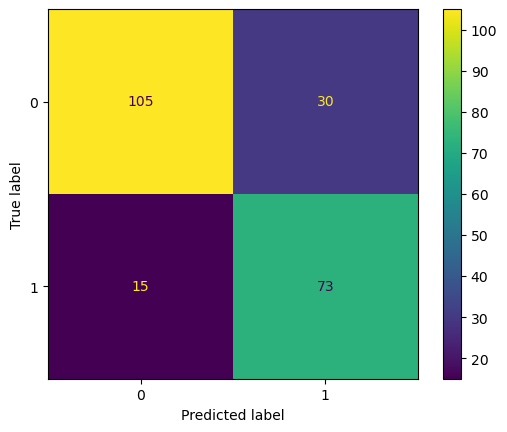

In [22]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(yLogPredictTest, y_test),
                       display_labels=logReg.classes_)

display.plot()

### data_Scaling

In [23]:
# As Age and Fare repreasented by larger numbers
# compared to other columns
# Age and Fare can be scaled for better performance

In [24]:
def get_data():
    df = pd.read_csv("./data/titanic_train.csv")
    df.set_index("PassengerId", inplace=True)
    df.drop(["Name", "Ticket", "Cabin", "Embarked"], axis=1, inplace=True)
    groupFilled = df.groupby("Sex")["Age"].transform("mean")
    df["Age"] = df["Age"].fillna(groupFilled)
    df["Sex"] = pd.get_dummies(df["Sex"], drop_first=True)
    return df

In [25]:
# As the final score depends on train_test_split
# we study statististical distirbution of accuracy score

In [26]:
score = {}

In [27]:
df = get_data()
X, y = df.drop("Survived", axis = 1), df["Survived"]

myList = []
for i in range(5000):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    logReg = LogisticRegression(max_iter=1000)
    logReg.fit(X_train, y_train)
    logPred = logReg.predict(X_test)
    myList.append(accuracy_score(logPred, y_test))
score["Non"] = myList

In [28]:
df = get_data()

scale = StandardScaler()
myList = []
for i in range(5000):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    X_train[["Age","Fare"]] = scale.fit_transform(X_train[["Age","Fare"]])
    X_test[["Age","Fare"]] = scale.transform(X_test[["Age","Fare"]])
    logReg = LogisticRegression(max_iter=1000)
    logReg.fit(X_train, y_train)
    logPred = logReg.predict(X_test)
    myList.append(accuracy_score(logPred, y_test))
score["StandardScaler"] = myList

In [29]:
df = get_data()

scale = MinMaxScaler()
myList = []
for i in range(5000):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    X_train[["Age","Fare"]] = scale.fit_transform(X_train[["Age","Fare"]])
    X_test[["Age","Fare"]] = scale.transform(X_test[["Age","Fare"]])
    logReg = LogisticRegression(max_iter=1000)
    logReg.fit(X_train, y_train)
    logPred = logReg.predict(X_test)
    myList.append(accuracy_score(logPred, y_test))
score["MinMaxScaler"] = myList

In [30]:
df = get_data()
scale = MinMaxScaler()
myList = []
for i in range(5000):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    X_train[["Age","Fare"]] = scale.fit_transform(X_train[["Age","Fare"]])
    X_test[["Age","Fare"]] = scale.transform(X_test[["Age","Fare"]])
    logReg = LogisticRegression(max_iter=1000, class_weight='balanced')
    logReg.fit(X_train, y_train)
    logPred = logReg.predict(X_test)
    myList.append(accuracy_score(logPred, y_test))
score["BalanceddMinMaxScaler"] = myList

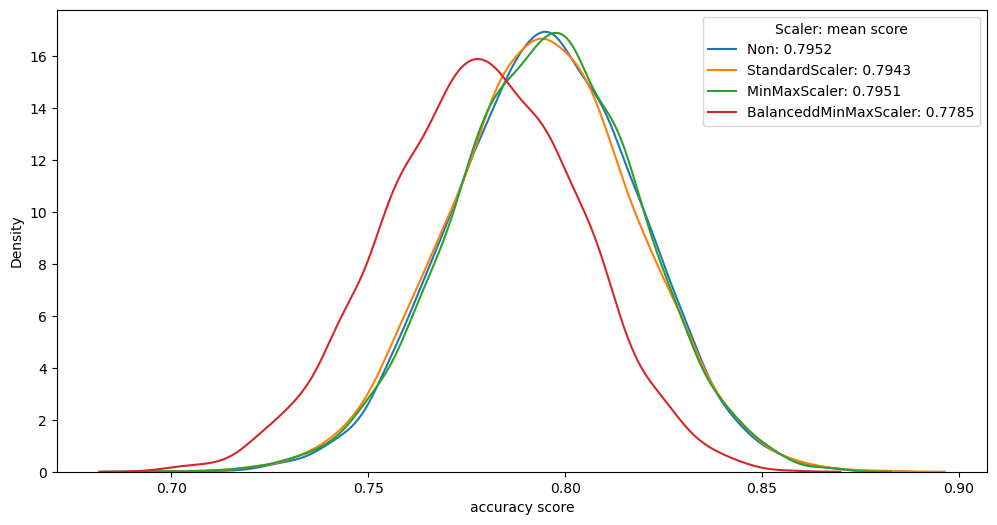

In [31]:
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(12,6))
for key in score.keys():
    sns.distplot(score[key], hist=False, label=f"{key}: {round(np.mean(score[key]), 4)}")
plt.legend()
plt.xlabel("accuracy score")
plt.legend(title = "Scaler: mean score")

# RandomForest

In [32]:
# A beter score can be obtained by RandomForest

In [33]:
df = get_data()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

ents = RandomForestClassifier(max_depth=9)
ents.fit(X_train, y_train)
print(f"accuracy score: train {accuracy_score(ents.predict(X_train), y_train)}, test {accuracy_score(ents.predict(X_test),y_test)}")

accuracy score: train 0.9339887640449438, test 0.8324022346368715


## Hyperparameters_search

In [34]:
# tuning of hyperparameters can improve score
# and avoid overfiting problem
# In this particular case
# depth of Forest should be 5
# which after accuracy of the test data stops growing

Text(0, 0.5, 'accuracy score')

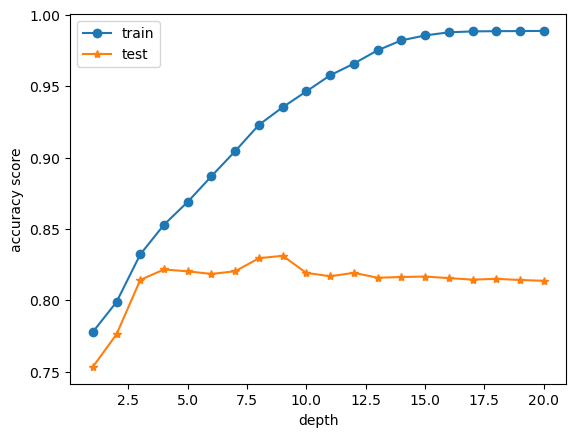

In [35]:
avScoreTr, avScoreTe  = {}, {}

for i in range(20):
    avgTr, avgTe = [], []
    for j in range(80):
        ents = RandomForestClassifier(max_depth=i+1)
        avgTr.append(accuracy_score(ents.fit(X_train, y_train).predict(X_train), y_train))
        avgTe.append(accuracy_score(ents.predict(X_test),y_test))
    avScoreTr[i+1]=np.mean(avgTr)
    avScoreTe[i+1]=np.mean(avgTe)

plt.plot(avScoreTr.keys(),avScoreTr.values(), "-o", label = "train")
plt.plot(avScoreTe.keys(),avScoreTe.values(), "-*", label = "test")


plt.legend()
plt.xlabel("depth")
plt.ylabel("accuracy score")

In [36]:
for i in [2,4,8]:
    ents = RandomForestClassifier(max_depth=i, random_state=1)
    ents.fit(X_train, y_train)
    predicted = ents.predict(X_test)
    entsAccuracy = accuracy_score(predicted, y_test)

    crossM = cross_val_score(estimator = ents,
                                         y=y_test,
                                         X=X_test,
                                         scoring="accuracy",
                                         cv=10,
                                         verbose=0)
    print(f"Difference @ {i} [%]: ", np.abs(crossM.mean()-entsAccuracy)*100)
    print("==========================================")

Difference @ 2 [%]:  1.1238908971409778
Difference @ 4 [%]:  0.028298097637569075
Difference @ 8 [%]:  5.040712746923715


# Pipelines

In [37]:
df = pd.read_csv("./data/titanic_train.csv")

def fillNa(DF):
    groupToFill = DF.groupby("Sex")["Age"].transform("mean")
    DF["Age"] = DF["Age"].fillna(groupToFill)
    return DF["Age"]

transformerNa = FunctionTransformer(fillNa)
df["Age"] = transformerNa.fit_transform(df)

superFlow = ColumnTransformer([
    ('MakeSexDummy',    OneHotEncoder(drop='first'), ['Sex']),
    ("ScaleAgeFare", StandardScaler(), ["Age", "Fare"]),
    ('letItBe', 'passthrough', ["SibSp", "Parch"])
])

In [38]:
logReg = Pipeline(steps=
                  [('DataEngineering', superFlow),
                   ('Algo', LogisticRegression(max_iter=1000))
                  ])

forestGump = Pipeline(steps=
                  [('DataEngineering', superFlow),
                   ('Algo', RandomForestClassifier(max_depth=4))
                  ])

vectorSupportPoly = Pipeline(steps=
                  [('DataEngineering', superFlow),
                   ('Algo', SVC(kernel='poly', degree=7))
                  ])

vectorSupportRBF = Pipeline(steps=
                  [('DataEngineering', superFlow),
                   ('Algo', SVC(kernel='rbf', degree=7))
                  ])

vectorSupportSigmoid = Pipeline(steps=
                  [('DataEngineering', superFlow),
                   ('Algo', SVC(kernel='sigmoid', degree=7))
                  ])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [40]:
logReg.fit(X_train, y_train)
forestGump.fit(X_train, y_train)
vectorSupportPoly.fit(X_train, y_train)
vectorSupportRBF.fit(X_train, y_train)
vectorSupportSigmoid.fit(X_train, y_train)

Pipeline(steps=[('DataEngineering',
                 ColumnTransformer(transformers=[('MakeSexDummy',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex']),
                                                 ('ScaleAgeFare',
                                                  StandardScaler(),
                                                  ['Age', 'Fare']),
                                                 ('letItBe', 'passthrough',
                                                  ['SibSp', 'Parch'])])),
                ('Algo', SVC(degree=7, kernel='sigmoid'))])

In [41]:
print("===LogisticRegration====")
print(logReg.score(X_test, y_test))
print("===RandomForest====")
print(forestGump.score(X_test, y_test))
print("===SVM (Poly)====")
print(vectorSupportPoly.score(X_test, y_test))
print("===SVM (RBF)====")
print(vectorSupportRBF.score(X_test, y_test))
print("===SVM (Sigmoid)====")
print(vectorSupportRBF.score(X_test, y_test))

===LogisticRegration====
0.7653631284916201
===RandomForest====
0.7932960893854749
===SVM (Poly)====
0.6871508379888268
===SVM (RBF)====
0.8100558659217877
===SVM (Sigmoid)====
0.8100558659217877


In [42]:
# read the data
df_test = pd.read_csv("./data/titanic_test.csv")

df_test.set_index("PassengerId", inplace=True)

df_test.drop("Name, Ticket, Cabin, Embarked".split(", "), axis=1, inplace=True)

df_test["Sex"] = pd.get_dummies(df_test["Sex"], drop_first=True)

<AxesSubplot:ylabel='PassengerId'>

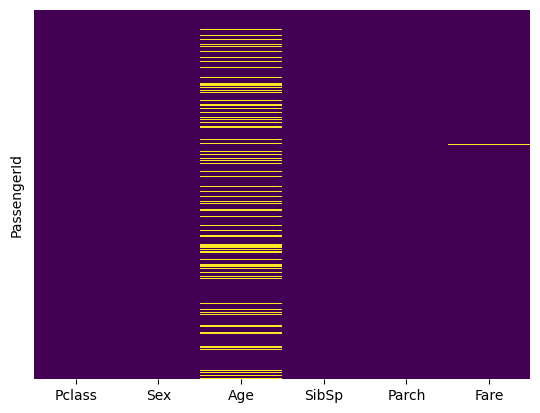

In [43]:
# exploring missing data
sns.heatmap(df_test.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [44]:
# fill missing data

missing_idx = df_test["Age"].isna()
df_test["Age"].fillna(df_test[missing_idx].apply(lambda x: df_mean_age[x["Sex"]][x["Pclass"]], axis=1),inplace=True)

missing_idx = df_test["Fare"].isna()
df_test["Fare"].fillna(df_test[missing_idx].apply(lambda x: np.mean(df_test["Fare"]), axis=1),inplace=True)

X_test = df_test

In [45]:

X_test, y_test = df.drop("Survived", axis = 1), df["Survived"]